# Bended Gaussian Fitting

## Import Libraries and Read and Plot Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.constants import Avogadro as Av
import os
from scipy.stats import gaussian_kde
import fastkde as kde
from matplotlib.colors import LogNorm
import sys

In [2]:
sys.path.append("../scripts/")

In [3]:
from utils import CCS_from_K0_inv

In [4]:

def CCS_from_K0_inv(K0_inv, charge, mass):
    mass = mass + charge * 1.00727647 # in g/mol
    CCS = K0_inv / (np.sqrt(305 * mass * 28.014 / (28.014 + mass)) * 1/18500 * 1/charge)
    return CCS # in Angstrom^2


In [5]:
root_path = os.getenv("DATA_DIR")
data_path = os.path.join(root_path, "two_populations", "evidence_aligned_train_v2660.csv")

In [6]:
# Read the CSV file
data = pd.read_csv(data_path, header=0, sep=',', usecols=["Sequence", "Modified sequence","Charge","m/z","Aligned 1/K0","Intensity","Reverse","Potential contaminant", "Mass", "Length"])

# Filter the data
data = data[data.Reverse.isna()]
data = data[data["Potential contaminant"].isna()]
data = data[data["Intensity"] > 0]

# Add the new columns
data["m"] = data["Mass"]
data["CCS"] = CCS_from_K0_inv(data["Aligned 1/K0"], data["Charge"], data["m"])
data["Length"] = data["Length"]

print(data.shape)

(2626006, 12)


In [7]:
data_2 = data.loc[data.Charge == 2,:]
m_2 = data_2.m / 1000 # kg/mol
CCS_2 = data_2.CCS / 100 # nm^2

data_3 = data.loc[data.Charge == 3,:]
m_3 = data_3.m / 1000 # kg/mol
CCS_3 = data_3.CCS / 100 # nm^2

data_4 = data.loc[data.Charge == 4,:]
m_4 = data_4.m / 1000 # kg/mol
CCS_4 = data_4.CCS / 100 # nm^2


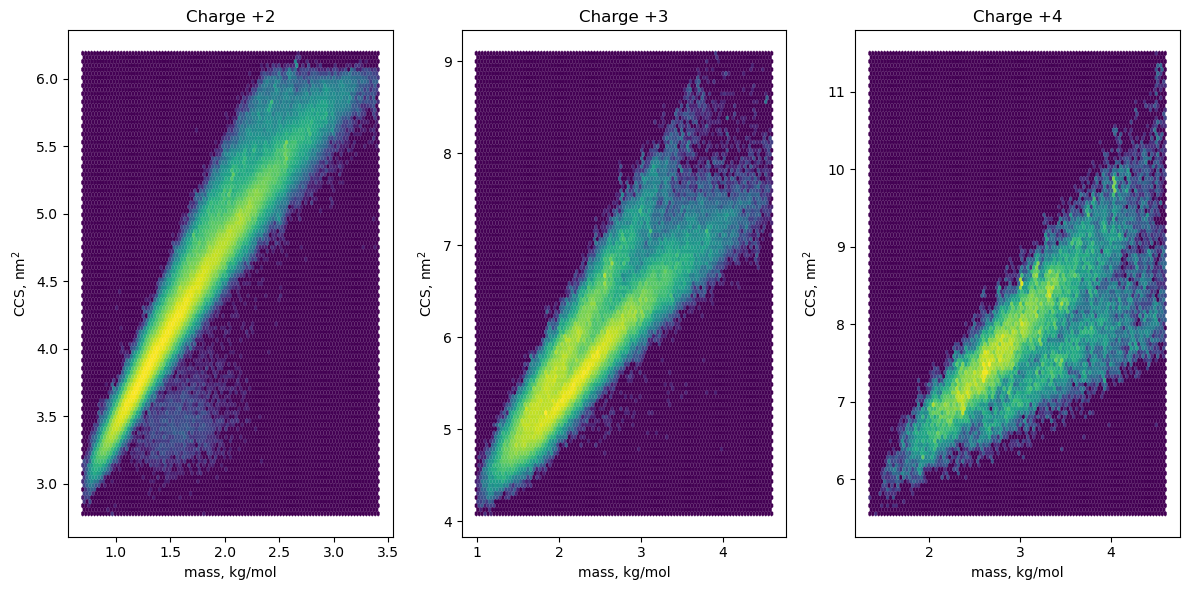

In [8]:
fig = plt.figure(figsize=(12,6))

data_list = [data_2, data_3, data_4]
titles = ['Charge +2', 'Charge +3', 'Charge +4']
axes = []

for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    ax.hexbin(data_list[i].m/1000, data_list[i].CCS/100,
              gridsize = 100, cmap='viridis',linewidths=0.1, bins = "log")
    ax.set_ylabel('CCS, nm$^2$')
    ax.set_xlabel('mass, kg/mol')
    ax.set_title(titles[i])
    axes.append(ax)

plt.tight_layout()

# Curved Gaussian Fit

In [9]:
def calculate_normalized_counts(m, CCS):
    counts, edges_m, edges_CCS = np.histogram2d(m, CCS, bins=100)
    m_centr = (edges_m[1:] + edges_m[:-1]) / 2
    CCS_centr = (edges_CCS[1:] + edges_CCS[:-1]) / 2
    #create a meshgrid
    temp = np.meshgrid(m_centr, CCS_centr, copy=True, sparse=False, indexing='ij')
    m_CCS_count = np.column_stack([temp[0].ravel(order='C'), temp[1].ravel(order='C'), counts.ravel(order='C')])
    #remove zeros
    m_CCS_count = m_CCS_count[m_CCS_count[:,2] > 0 , : ]
    #normalize
    m_CCS_count_norm = np.copy(m_CCS_count)
    m_CCS_count_norm[:,2] = m_CCS_count_norm[:,2] / m_CCS_count_norm[:,2].sum()

    return m_CCS_count_norm

m_CCS_count_norm_2 = calculate_normalized_counts(m_2, CCS_2)
m_CCS_count_norm_3 = calculate_normalized_counts(m_3, CCS_3)
m_CCS_count_norm_4 = calculate_normalized_counts(m_4, CCS_4)

This Python code is creating 2D histograms for three different datasets (`m_2, CCS_2`, `m_3, CCS_3`, and `m_4, CCS_4`), removing zero counts, and normalizing the counts. Here's a step-by-step explanation:

For each dataset:

1. It uses `np.histogram2d` to create a 2D histogram with 100 bins. This function returns the counts and the bin edges for the two dimensions (`m` and `CCS`).

2. It calculates the center of each bin by averaging the edges. This is done for both dimensions.

3. It creates a meshgrid from the bin centers. A meshgrid is a coordinate grid with one axis for each dimension, in this case `m_centr` and `CCS_centr`. The `indexing='ij'` argument means that the first index of the resulting array varies the fastest, which is the standard in Python.

4. It reshapes the meshgrid and the counts into 1D arrays and stacks them into a 2D array `m_CCS_count` with three columns: `m`, `CCS`, and `count`.

5. It removes rows from `m_CCS_count` where the count is zero.

6. It normalizes the counts by dividing each count by the total sum of counts. This is done in a copy of `m_CCS_count` to preserve the original counts.

This process is repeated for each of the three datasets, resulting in three normalized 2D histograms: `m_CCS_count_norm_2`, `m_CCS_count_norm_3`, and `m_CCS_count_norm_4`.

# joint fit, variable gauss ratio

In [10]:
# maximize logp
from scipy import optimize
from scipy.stats import skewnorm

def skew_normal_pdf(x, xi, omega, alpha):
    return 2 * skewnorm.pdf(x, alpha, loc=xi, scale=omega) * skewnorm.cdf(alpha * (x - xi) / omega)


def double_skew_nonequalamount(m, CCS, m_center_sphere, m_center_cylinder, sigma_m, sigma_CCS, fit_factor, density, r, offset, sphere_cylinder_ratio, r1, alpha_sphere, alpha_cylinder):
    sphere_prediction_at_m = mass_invK0_spherical_offset(m, fit_factor, density, offset)
    skew_sphere = skewnorm(alpha_sphere, loc=m_center_sphere, scale=sigma_m)
    rho_sphere = np.exp(-0.5 * ((m - skew_sphere.rvs(size=len(m)))**2 / sigma_m**2 + (CCS - sphere_prediction_at_m)**2 / sigma_CCS**2))

    cylinder_prediction_at_m = mass_invK0_cylinder_offset(m, fit_factor, density, r, offset)
    skew_cylinder = skewnorm(alpha_cylinder, loc=m_center_cylinder, scale=sigma_m)
    rho_cylinder = np.exp(-0.5 * ((m - skew_cylinder.rvs(size=len(m)))**2 / sigma_m**2 + (CCS - cylinder_prediction_at_m)**2 / sigma_CCS**2))

    lin_ratio = sphere_cylinder_ratio + m * r1
    rho = lin_ratio * rho_sphere + (1 - lin_ratio) * rho_cylinder

    # normalization
    rho /= rho.sum()
    return rho


def double_gauss_nonequalamount(m,CCS,m_center_sphere,m_center_cylinder,sigma_m,sigma_CCS,fit_factor,density,r,offset,sphere_cylinder_ratio, r1):
        
    sphere_prediction_at_m = mass_invK0_spherical_offset(m,fit_factor,density,offset)
    rho_sphere = np.exp(-1 * ((m-m_center_sphere)**2/(2*sigma_m**2) + (CCS - sphere_prediction_at_m)**2/(2*sigma_CCS**2)))
    
    cylinder_prediction_at_m = mass_invK0_cylinder_offset(m,fit_factor,density,r,offset)
    rho_cylinder = np.exp(-1 * ((m-m_center_cylinder)**2/(2*sigma_m**2) + (CCS - cylinder_prediction_at_m)**2/(2*sigma_CCS**2)))


    lin_ratio = sphere_cylinder_ratio + m * r1
    rho = lin_ratio * rho_sphere + (1 - lin_ratio) * rho_cylinder
    #normalization
    rho /= rho.sum()
    return rho

def mass_invK0_spherical_offset(m,fit_factor,density,offset):
    volume = 1e27 *  m * (1/density) / Av # nm^3 / molecule
    r = (3*volume / (4*np.pi))**(1/3)
    projected_area = np.pi * r * r
    return fit_factor * projected_area + offset

def mass_invK0_cylinder_offset(m,fit_factor,density,r,offset):
    volume = 1e27 *  m * (1/density) / Av # nm^3 / molecule
    L = volume / (r * r * np.pi)
    projected_area = (r*r*np.pi + r*L*np.pi) / 2
    return fit_factor * projected_area + offset

In [11]:
density = 1000

# Define the argument dictionary
arg_dict = {
    'm_center_sphere': [0, 7, 11],
    'm_center_cylinder': [1, 8, 12],
    'sigma_m': [2, 9, 13],
    'sigma_CCS': [3, 10, 14],
    'size_factor': 4,
    'r': 5,
    'intercept': 6,
    'sphere_frac': [15, 16, 17],
    'r1': [18, 19, 20]
}

# m_center,m_center, sigma_m,sigma_CCS,size_factor,r,intercept
initial_guess = np.concatenate([np.array([1.46,1.47, 0.43, 0.09, 1.3, 0.75, 0.56]),
                 np.array([2.19,2.01, 0.50, 0.16 ]),
                 np.array([3.44,2.75, 0.53, 0.27]),
                 np.array([0.5,0.5,0.5]),
                 np.array([0.0,0.0,0.0])])

def cost_fun_joint(argument_pack):
    # Unpack the arguments using the dictionary
    m_center_sphere = argument_pack[arg_dict['m_center_sphere']]
    m_center_cylinder = argument_pack[arg_dict['m_center_cylinder']]
    sigma_m = argument_pack[arg_dict['sigma_m']]
    sigma_CCS = argument_pack[arg_dict['sigma_CCS']]
    size_factor = argument_pack[arg_dict['size_factor']]
    r = argument_pack[arg_dict['r']]
    intercept = argument_pack[arg_dict['intercept']]
    sphere_frac = argument_pack[arg_dict['sphere_frac']]
    r1 = argument_pack[arg_dict['r1']]

    # Calculate the cost for each charge state
    diff_sqr = np.zeros(3)
    for i in range(3):
        rho = double_gauss_nonequalamount(m_CCS_count_norm[i][:,0], m_CCS_count_norm[i][:,1], m_center_sphere[i], m_center_cylinder[i], sigma_m[i], sigma_CCS[i], size_factor, density, r, intercept*(i+2), sphere_frac[i], r1[i])
        diff_sqr[i] = ((m_CCS_count_norm[i][:,2] - rho)**2).sum()

    return diff_sqr.sum()

# Define m_CCS_count_norm
m_CCS_count_norm = [m_CCS_count_norm_2, m_CCS_count_norm_3, m_CCS_count_norm_4]

res = optimize.minimize(cost_fun_joint, initial_guess, bounds=((m_2.min(),m_2.max()), (m_2.min(),m_2.max()), (0.01,1),(0.01,1), (0.1,2), (0.1,2.1), (0.1,0.67*4), (m_3.min(),m_3.max()), (m_3.min(),m_3.max()), (0.01,1),(0.01,1), (m_4.min(),m_4.max()), (m_4.min(),m_4.max()), (0.01,1),(0.01,1), (0,1),(0,1),(0,1), (0,1),(0,1),(0,1)))
res

      fun: 0.00040870828231926283
 hess_inv: <21x21 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.81250175e-06, -5.60911452e-06, -2.19005586e-06, -2.61879656e-05,
        2.65456765e-05, -2.65664227e-06,  2.45689049e-05, -6.69652051e-07,
       -3.93175618e-06,  7.67831979e-07, -9.17001934e-07,  2.34611592e-06,
        1.33542808e-06, -8.94813737e-07, -1.89869821e-06,  3.75745442e-06,
       -7.37468897e-07, -1.39873464e-06,  2.26341352e-05, -4.69698065e-07,
       -3.25629823e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2354
      nit: 95
   status: 0
  success: True
        x: array([1.47878998, 1.61990328, 0.42328539, 0.09531955, 1.33772118,
       0.75069832, 0.58630061, 2.13877559, 2.09813827, 0.50748226,
       0.20696287, 3.43356014, 2.79027613, 0.52067194, 0.28187377,
       0.9412764 , 0.57022051, 0.04188804, 0.        , 0.08860659,
       0.04717751])

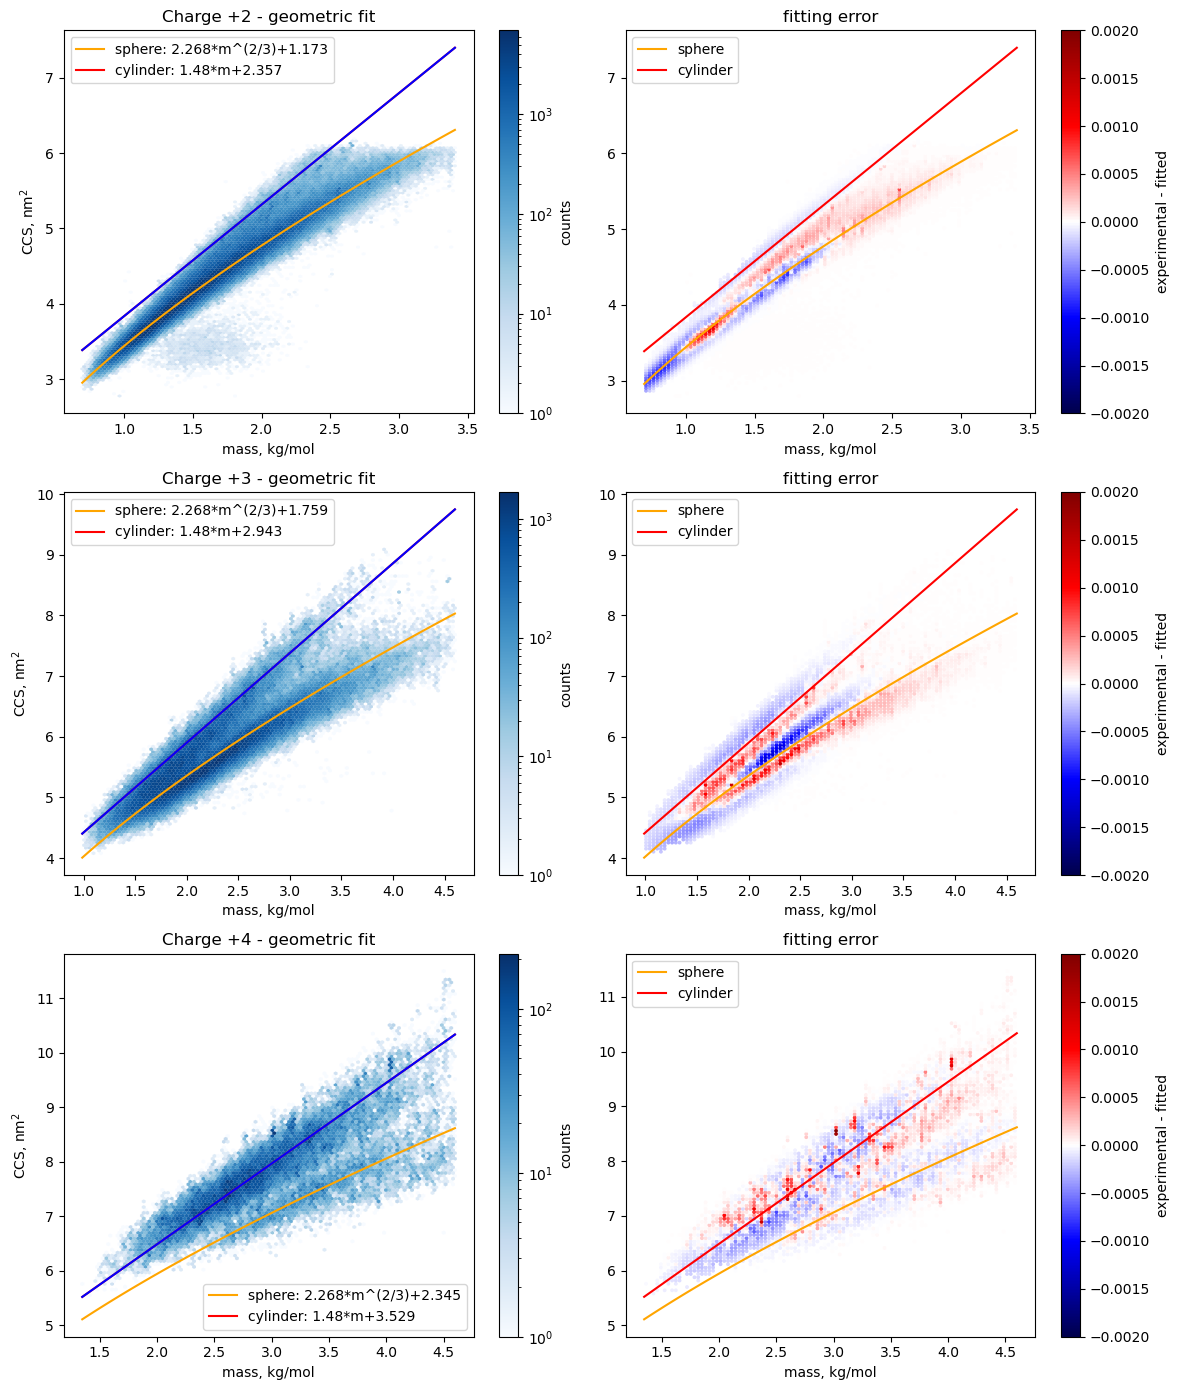

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(12,14))
charge_states = [2, 3, 4]
masses = [m_2, m_3, m_4]
CCSs = [CCS_2, CCS_3, CCS_4]
m_CCS_counts = [m_CCS_count_norm_2, m_CCS_count_norm_3, m_CCS_count_norm_4]
res_indices = [(0, 1, 2, 3, 15, 18), (7, 8, 9, 10, 16, 19), (11, 12, 13, 14, 17, 20)]
error_lim = (-0.002,0.002)

for i, charge_state, mass, CCS, m_CCS_count, res_index in zip(range(3), charge_states, masses, CCSs, m_CCS_counts, res_indices):
    ms = np.linspace(mass.min(), mass.max(), 100)
    hexbin = axs[i, 0].hexbin(mass, CCS, gridsize=100, linewidths=0.1, bins="log", mincnt=1, cmap='Blues')
    a = res.x[4]*np.pi*((3*1e27)/(4*np.pi*density*Av))**(2/3)
    b = res.x[6]*charge_state
    axs[i, 0].plot(ms, mass_invK0_spherical_offset(ms, res.x[4], density, res.x[6]*charge_state), color="orange", label=f"sphere: {np.round(a, 3)}*m^(2/3)+{np.round(b,3)}")
    a = res.x[4]*1e27/(2*res.x[5]*density*Av)
    b = res.x[4]*res.x[5]**2*np.pi/2 + res.x[6]*charge_state
    axs[i, 0].plot(ms, mass_invK0_cylinder_offset(ms, res.x[4], density, res.x[5], res.x[6]*charge_state), color="red", label=f"cylinder: {np.round(a, 3)}*m+{np.round(b,3)}")
    axs[i, 0].plot(ms, a*ms + b, '-b')
    axs[i, 0].set_ylabel('CCS, nm$^2$')
    axs[i, 0].set_xlabel('mass, kg/mol')
    axs[i, 0].set_title(f'Charge +{charge_state} - geometric fit')
    plt.colorbar(hexbin, ax=axs[i, 0], label="counts")
    axs[i, 0].legend()

    rho_opt = double_gauss_nonequalamount(m_CCS_count[:,0], m_CCS_count[:,1], res.x[res_index[0]], res.x[res_index[1]], res.x[res_index[2]], res.x[res_index[3]], res.x[4], density, res.x[5], res.x[6]*charge_state, res.x[res_index[4]], res.x[res_index[5]])
    difference = m_CCS_count[:,2] - rho_opt
    scatter = axs[i, 1].scatter(m_CCS_count[:,0], m_CCS_count[:,1], c=difference, cmap="seismic", s=3, vmin=error_lim[0], vmax=error_lim[1])
    axs[i, 1].plot(ms, mass_invK0_spherical_offset(ms, res.x[4], density, res.x[6]*charge_state), color="orange", label="sphere")
    axs[i, 1].plot(ms, mass_invK0_cylinder_offset(ms, res.x[4], density, res.x[5], res.x[6]*charge_state), color="red", label="cylinder")
    axs[i, 1].set_xlabel("mass, kg/mol")
    axs[i, 1].set_title("fitting error")
    plt.colorbar(scatter, ax=axs[i, 1], label="experimental - fitted")
    axs[i, 1].legend()

plt.tight_layout()
#plt.savefig("/home/dszoell/ownCloud/drift_chamber/manuscript/figs/sph_cyl_fit_charge2_4_nonequalgauss.png",dpi=300)

In [13]:
def sphere_probability_after_fit(m,CCS,m_center_sphere,m_center_cylinder,sigma_m,sigma_CCS,fit_factor,r,offset, ratio, linear_dependence):
     density = 1000 #given
     """
     m: mass in kg/mol, original mass value *1e-3
     CCS: in nm^2, original value *1e-2
     m_center_sphere: gauss center for the sphere model
     m_center_cylinder: gauss center for the cylinder model
     sigma_m: width in mass dimension
     sigma_CCS: width in the CCS dimension, now mass independent
     fit_factor: apparent size increase due to inaccurate density and ranged interactions like LJ
     density = 1000 kg/m^3, fixed
     r: cylinder radius in nm
     offset: charge related increase of the CCS in nm^2

     """
     #CCS at given mass and fit_factor and offset if having spherical shape
     sphere_prediction_at_m = mass_invK0_spherical_offset(m,fit_factor,density,offset)
     #likelihood of being spherical given mass, and gauss parameters
     rho_sphere = np.exp(-1 * ((m-m_center_sphere)**2/(2*sigma_m**2) + (CCS - sphere_prediction_at_m)**2/(2*sigma_CCS**2)))

     #CCS at given mass, radius and fit_factor and offset if having cylindrical shape
     cylinder_prediction_at_m = mass_invK0_cylinder_offset(m,fit_factor,density,r,offset)
     #likelihood of being cylindrical given mass, and gauss parameters
     rho_cylinder = np.exp(-1 * ((m-m_center_cylinder)**2/(2*sigma_m**2) + (CCS - cylinder_prediction_at_m)**2/(2*sigma_CCS**2)))

     ratio_lin = ratio + m * linear_dependence
     rho_sphere = rho_sphere * ratio_lin
     rho_cylinder = rho_cylinder * (1 - ratio_lin)


     #probablity of being spherical, given fitted parameters
     p_sphere = rho_sphere / (rho_sphere+rho_cylinder)

     return p_sphere

In [14]:
data.loc[data.Charge == 2, "sphere_prob"] = sphere_probability_after_fit(m_2,CCS_2,res.x[0],res.x[1],res.x[2],res.x[3],res.x[4],res.x[5],res.x[6]*2, res.x[15], res.x[18])

In [15]:
data.loc[data.Charge == 3, "sphere_prob"] = sphere_probability_after_fit(m_3,CCS_3,res.x[7],res.x[8],res.x[9],res.x[10],res.x[4],res.x[5],res.x[6]*3, res.x[16], res.x[19])

In [16]:
data.loc[data.Charge == 4, "sphere_prob"] = sphere_probability_after_fit(m_4,CCS_4,res.x[11],res.x[12],res.x[13],res.x[14],res.x[4],res.x[5],res.x[6]*4, res.x[17], res.x[20])

## Labeling

In [17]:
data.loc[data.Charge == 2, "cluster_down"] = data.loc[data.Charge == 2, "sphere_prob"] >= 0.5
data.loc[data.Charge == 3, "cluster_down"] = data.loc[data.Charge == 3, "sphere_prob"] >= 0.5
data.loc[data.Charge == 4, "cluster_down"] = data.loc[data.Charge == 4, "sphere_prob"] >= 0.5

In [18]:
data.loc[data.Charge == 2, "cluster_up"] = data.loc[data.Charge == 2, "sphere_prob"] < 0.5
data.loc[data.Charge == 3, "cluster_up"] = data.loc[data.Charge == 3, "sphere_prob"] < 0.5
data.loc[data.Charge == 4, "cluster_up"] = data.loc[data.Charge == 4, "sphere_prob"] < 0.5

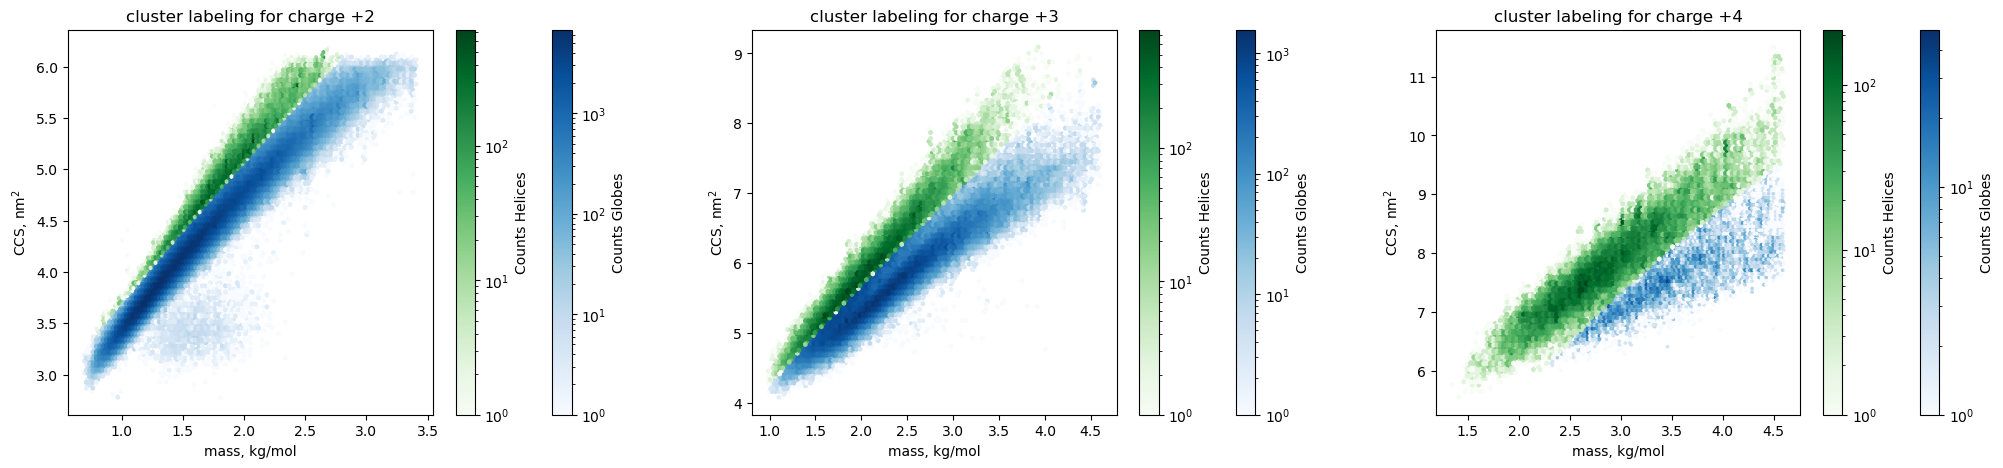

In [19]:
#plot the labeling
fig, axs = plt.subplots(figsize=(25,5), nrows=1, ncols = 3)

for i, charge in enumerate([2,3,4]):
    data_charge = data.loc[data.Charge == charge,:]
    ax = axs[i]

    hb1 = ax.hexbin(data_charge.loc[data_charge.cluster_down,"m"]/1000,
               data_charge.loc[data_charge.cluster_down,"CCS"]/100,
               gridsize=100, bins='log', cmap="Blues", mincnt=1)
    hb2 = ax.hexbin(data_charge.loc[data_charge.cluster_up,"m"]/1000,
               data_charge.loc[data_charge.cluster_up,"CCS"]/100,
               gridsize=100, bins='log', cmap="Greens", mincnt=1)
    ax.set_xlabel("mass, kg/mol")
    ax.set_ylabel("CCS, nm$^2$")
    ax.set_title(f"cluster labeling for charge +{charge}")
    plt.colorbar(hb1, ax=ax, label="Counts Globes")
    plt.colorbar(hb2, ax=ax, label="Counts Helices")

In [21]:
#how many points are in each population?
data.loc[data.Charge == 2, "cluster_up"].sum()/data.loc[data.Charge == 2].shape[0], data.loc[data.Charge == 3, "cluster_up"].sum()/data.loc[data.Charge == 3].shape[0], data.loc[data.Charge == 4, "cluster_up"].sum()/data.loc[data.Charge == 4].shape[0]

(0.041103813991021323, 0.20011641198622693, 0.8115033217254982)

In [20]:
from scipy.optimize import curve_fit

In [21]:
data["Aligned CCS"] = CCS_from_K0_inv(data["Aligned 1/K0"], data["Charge"], data["Mass"])

In [22]:
# Define the functions to fit
def func0(x, a, b):
    return a * x + b

def func1(x, a, b):
    return a * np.power(x, 2/3) + b

# Initialize dictionaries to store models for each charge
models = {}

# Iterate over each charge
for charge in [2,3,4]:
    # Filter data for current charge
    cluster_down = data[(data['Charge'] == charge) & (data['cluster_down'])]
    cluster_up = data[(data['Charge'] == charge) & (data['cluster_up'])]

    # Fit the functions using curve_fit
    if charge != 2:
        popt0, pcov0 = curve_fit(func0, cluster_up["Mass"], cluster_up["Aligned CCS"])
        popt1, pcov1 = curve_fit(func1, cluster_down["Mass"], cluster_down["Aligned CCS"])
    else:
        popt0, pcov0 = curve_fit(func0, cluster_up["Mass"], cluster_up["Aligned CCS"])
        popt1, pcov1 = curve_fit(func1, cluster_down["Mass"], cluster_down["Aligned CCS"])

    # Store the parameters of the fitted functions
    models[charge] = [popt0, popt1]

In [23]:
from scipy.stats import median_abs_deviation

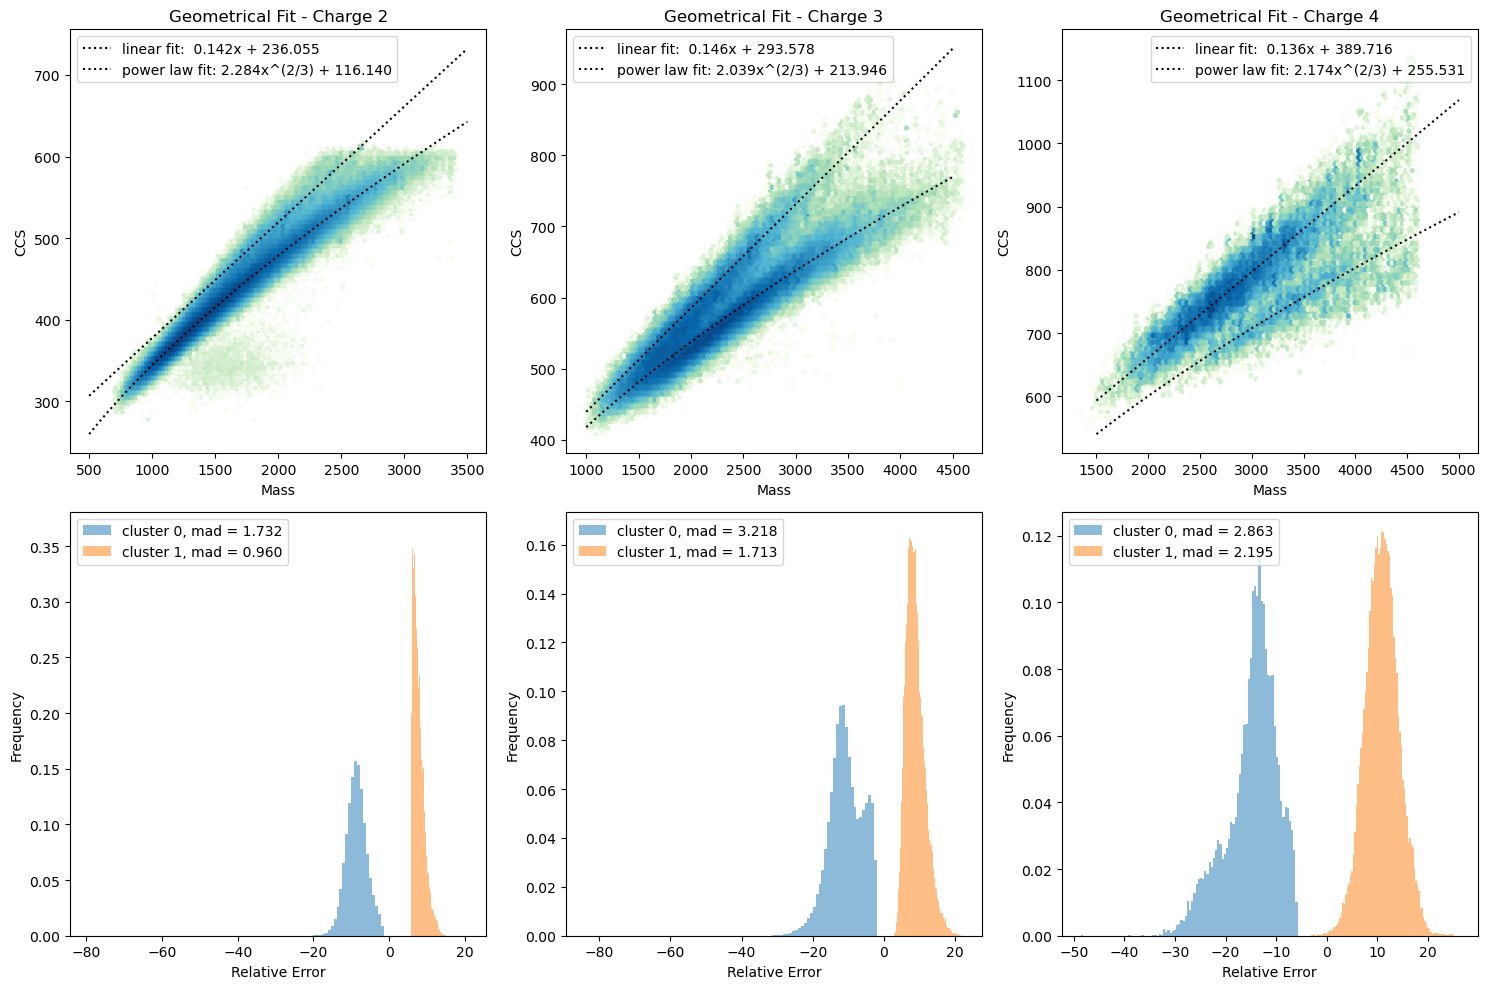

In [24]:
fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=3)

charge_states = [2, 3, 4]

for i, charge in enumerate(charge_states):
    cluster0 = data[(data['Charge'] == charge) & (data['cluster_down'])]
    cluster1 = data[(data['Charge'] == charge) & (data['cluster_up'])]

    # Top row: Fit
    data_charge = data[data["Charge"] == charge]
    axs[0, i].hexbin(data_charge["Mass"], data_charge["Aligned CCS"], gridsize=100, bins='log', cmap="GnBu", mincnt=1)
    axs[0, i].set_title(f"Geometrical Fit - Charge {charge}")
    #generate the trend lines
    if charge == 2:
        x = np.linspace(500, 3500, 100).reshape(-1, 1)
    elif charge == 3:
        x = np.linspace(1000, 4500, 100).reshape(-1, 1)
    else:
        x = np.linspace(1500, 5000, 100).reshape(-1, 1)
    y0 = func0(x, *models[charge][0])
    y1 = func1(x, *models[charge][1])
    #plot the trend lines
    axs[0, i].plot(x, y0, label=f"linear fit:  {models[charge][0][0]:.3f}x + {models[charge][0][1]:.3f}", color = "black", linestyle="dotted")
    axs[0, i].plot(x, y1, label=f"power law fit: {models[charge][1][0]:.3f}x^(2/3) + {models[charge][1][1]:.3f}",color = "black", linestyle="dotted")
    axs[0, i].set_xlabel("Mass")
    axs[0, i].set_ylabel("CCS")
    axs[0, i].legend()

    # Bottom row: Error
    # Calculate the relative error and the median absolute deviation
    y0_pred = func0(cluster0["Mass"], *models[charge][0])
    error0 = (cluster0["Aligned CCS"] - y0_pred) / cluster0["Aligned CCS"] * 100
    mad0 = median_abs_deviation(error0)

    y1_pred = func1(cluster1["Mass"], *models[charge][1])
    error1 = (cluster1["Aligned CCS"] - y1_pred) / cluster1["Aligned CCS"] * 100
    mad1 = median_abs_deviation(error1)

    # Histogram of relative error
    axs[1, i].hist(error0, bins=100, label=f"cluster 0, mad = {mad0:.3f}", alpha=0.5, density=True)
    axs[1, i].hist(error1, bins=100, label=f"cluster 1, mad = {mad1:.3f}", alpha=0.5, density=True)
    axs[1, i].set_xlabel("Relative Error")
    axs[1, i].set_ylabel("Frequency")
    axs[1, i].legend()

plt.tight_layout()
plt.show()

In [26]:
plt.style.use("science")

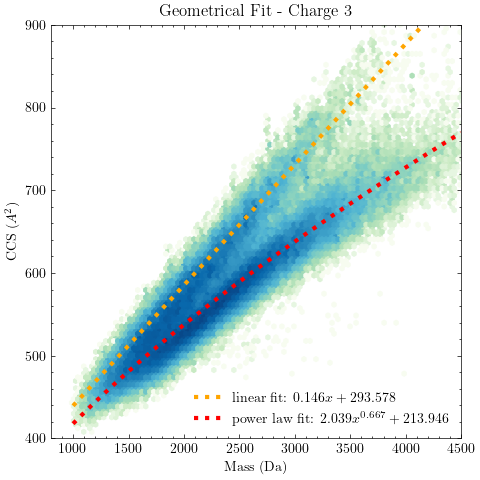

In [33]:
fig, axs = plt.subplots(figsize=(5, 5), nrows=1, ncols=1)

charge_states = [3]

for i, charge in enumerate(charge_states):
    cluster0 = data[(data['Charge'] == charge) & (data['cluster_down'])]
    cluster1 = data[(data['Charge'] == charge) & (data['cluster_up'])]

    # Top row: Fit
    data_charge = data[data["Charge"] == charge]
    axs.hexbin(data_charge["Mass"], data_charge["Aligned CCS"], gridsize=100, bins='log', cmap="GnBu", mincnt=1)
    axs.set_title(f"Geometrical Fit - Charge {charge}")
    #generate the trend lines
    if charge == 2:
        x = np.linspace(500, 3500, 100).reshape(-1, 1)
    elif charge == 3:
        x = np.linspace(1000, 4500, 100).reshape(-1, 1)
    else:
        x = np.linspace(1500, 5000, 100).reshape(-1, 1)
    y0 = func0(x, *models[charge][0])
    y1 = func1(x, *models[charge][1])
    #plot the trend lines
    axs.plot(x, y0, label=f"linear fit:  ${{{models[charge][0][0]:.3f}}}x + {{{models[charge][0][1]:.3f}}}$", color = "orange", linestyle="dotted", linewidth=3)
    axs.plot(x, y1, label=f"power law fit: ${{{models[charge][1][0]:.3f}}}x^{{{2/3:.3f}}} + {{{models[charge][1][1]:.3f}}}$",color = "red", linestyle="dotted", linewidth=3)
    axs.set_xlabel("Mass (Da)")
    axs.set_ylabel("CCS $(A^2)$")
    axs.legend()
    axs.set_ylim(400,900)
    axs.set_xlim(800, 4500)
    #colorbar

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Cluster 1')

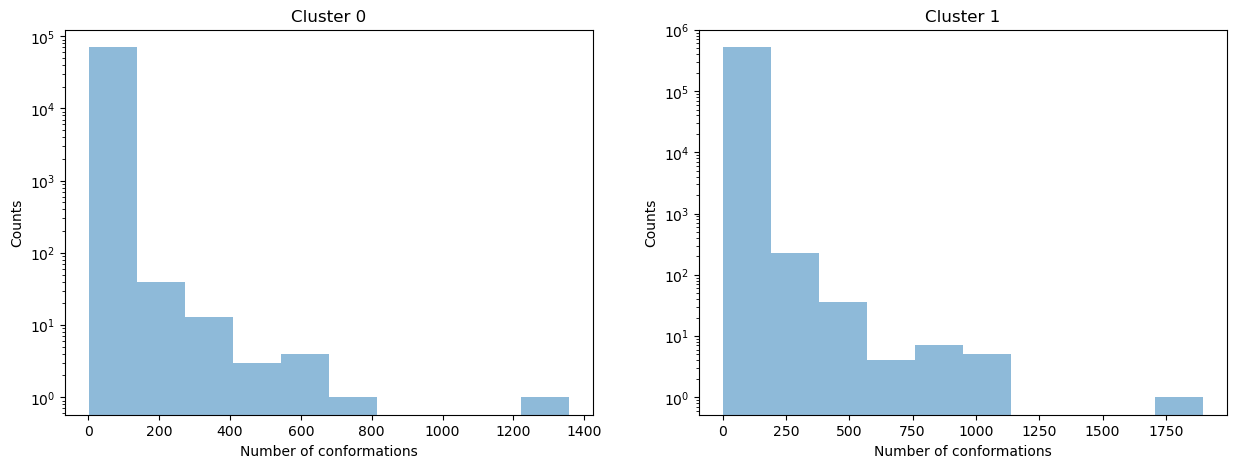

In [37]:
#group by Modified sequence, Charge and and count the number of rows in each cluster
n_c0 = data[data["cluster_up"]].groupby(["Modified sequence", "Charge"])["Aligned 1/K0"].size().reset_index(name="counts")
n_c1 = data[data["cluster_down"]].groupby(["Modified sequence", "Charge"])["Aligned 1/K0"].size().reset_index(name="counts")

#plot histogram of the log of the counts per conformations
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)
ax[0].hist(n_c0["counts"], bins=10, alpha=0.5, label="Cluster 0", log=True)
ax[0].set_xlabel("Number of conformations")
ax[0].set_ylabel("Counts")
ax[0].set_title("Cluster 0")

ax[1].hist(n_c1["counts"], bins=10, alpha=0.5, label="Cluster 1", log=True)
ax[1].set_xlabel("Number of conformations")
ax[1].set_ylabel("Counts")
ax[1].set_title("Cluster 1")

In [38]:

#take only the upper population
cluster_up = data[data["cluster_up"]]
# sort evidence by modified sequence, charge, and intensity
cluster_up = cluster_up.sort_values(by=["Modified sequence", "Charge", "Intensity"], ascending=False)
#group by modified sequence, charge and take the first row
first_up = cluster_up.groupby(["Modified sequence", "Charge"]).first().reset_index()
first_up["regressor"] = "upper"

#take only the lower population
cluster_low = data[data["cluster_down"]]
# sort evidence by modified sequence, charge and intensity
cluster_low = cluster_low.sort_values(by=["Modified sequence", "Charge", "Intensity"], ascending=False)
#group by modified sequence, charge and mean K0 and take the first row
first_down = cluster_low.groupby(["Modified sequence", "Charge"]).first().reset_index()
first_down["regressor"] = "lower"

#concatenate the two populations
train_unique = first_up.append(first_down)

train_unique["Mean 1/K0"] = train_unique["Aligned 1/K0"]
cluster_up["Mean 1/K0"] = cluster_up["Aligned 1/K0"]
cluster_low["Mean 1/K0"] = cluster_low["Aligned 1/K0"]

Text(0.5, 1.0, 'Both Clusters')

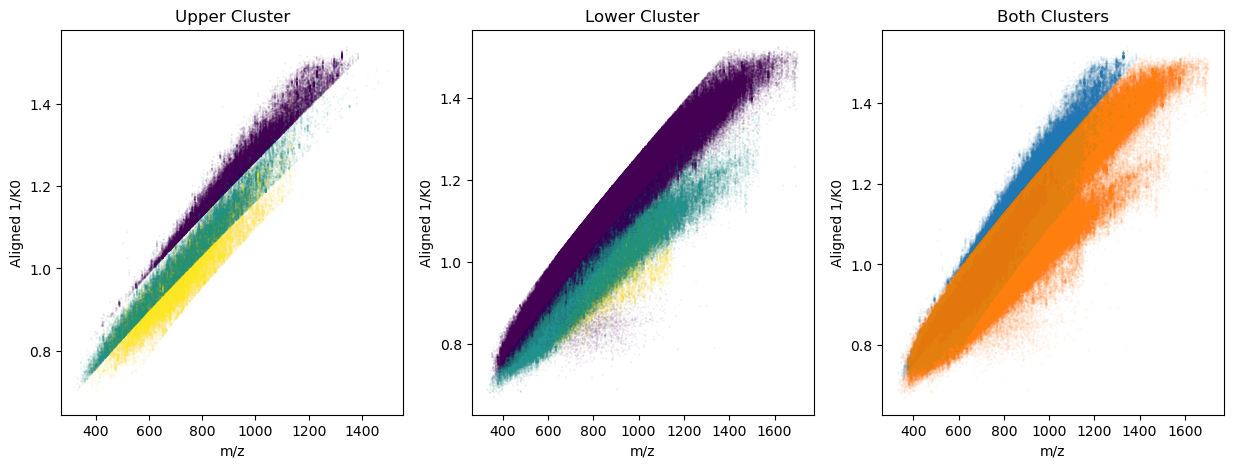

In [39]:
#create plots for upper cluster, lower cluster and both clusters
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=3)
#plot the upper cluster
ax[0].scatter(cluster_up["m/z"], cluster_up["Mean 1/K0"], s=0.1, alpha=0.1, c = cluster_up["Charge"])
ax[0].set_xlabel("m/z")
ax[0].set_ylabel("Aligned 1/K0")
ax[0].set_title("Upper Cluster")

#plot the lower cluster
ax[1].scatter(cluster_low["m/z"], cluster_low["Mean 1/K0"], s=0.1, alpha=0.1, c = cluster_low["Charge"])
ax[1].set_xlabel("m/z")
ax[1].set_ylabel("Aligned 1/K0")
ax[1].set_title("Lower Cluster")

#plot both clusters
ax[2].scatter(cluster_up["m/z"], cluster_up["Mean 1/K0"], s=0.1, alpha=0.1, label="Upper Cluster")
ax[2].scatter(cluster_low["m/z"], cluster_low["Mean 1/K0"], s=0.1, alpha=0.1, label="Lower Cluster")
ax[2].set_xlabel("m/z")
ax[2].set_ylabel("Aligned 1/K0")
ax[2].set_title("Both Clusters")

In [41]:
train_unique.shape

(592254, 17)

In [46]:
root_path = os.getenv("DATA_DIR")
#save train unique
train_unique.to_pickle(os.path.join(root_path, "two_populations",  "train_unique_daniel.pkl"))
#also save as csv
train_unique.to_csv(os.path.join(root_path, "two_populations", "train_unique_daniel.csv"), index=False)